# Text classification on "20 newsgroup" dataset

 we'll here make use of the famous ["20 newsgroups"]( http://qwone.com/~jason/20Newsgroups/) dataset to test our different classifiers and feature extractors. This dataset can be fetched from "scikit-learn" package using following commands. This package also provides different feature extractors and classifiers which we aim to do some experiments on it in this notebook to enhance the classification performance.

Let's first have a look at the data statistics before diving deep into training details

In [11]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import normalize
from collections import Counter
import matplotlib.pyplot as plt
import sklearn.svm as SVM
from sklearn.model_selection import train_test_split
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.svm import LinearSVC
import nltk
nltk.download('stopwords')


news = fetch_20newsgroups(subset='all')
print("Number of articles: ", len(news.data) )
print("Number of different categories: " , len(news.target_names) )


## Important note: IF you're wondering why our simple models outperform SoA in terms of accuracy, you should
## consider that the original test/train split is at 0.6, but this notebook uses its own random splitting at
## test/train split of 0.8 (which is set for educational purposes)

[nltk_data] Downloading package stopwords to /home/banaei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of articles:  18846
Number of different categories:  20


 We can see that this dataset has around 19K articles in 20 different news groups. Using following code, we can see the distribution of data in all 20 classes using a pie chart.

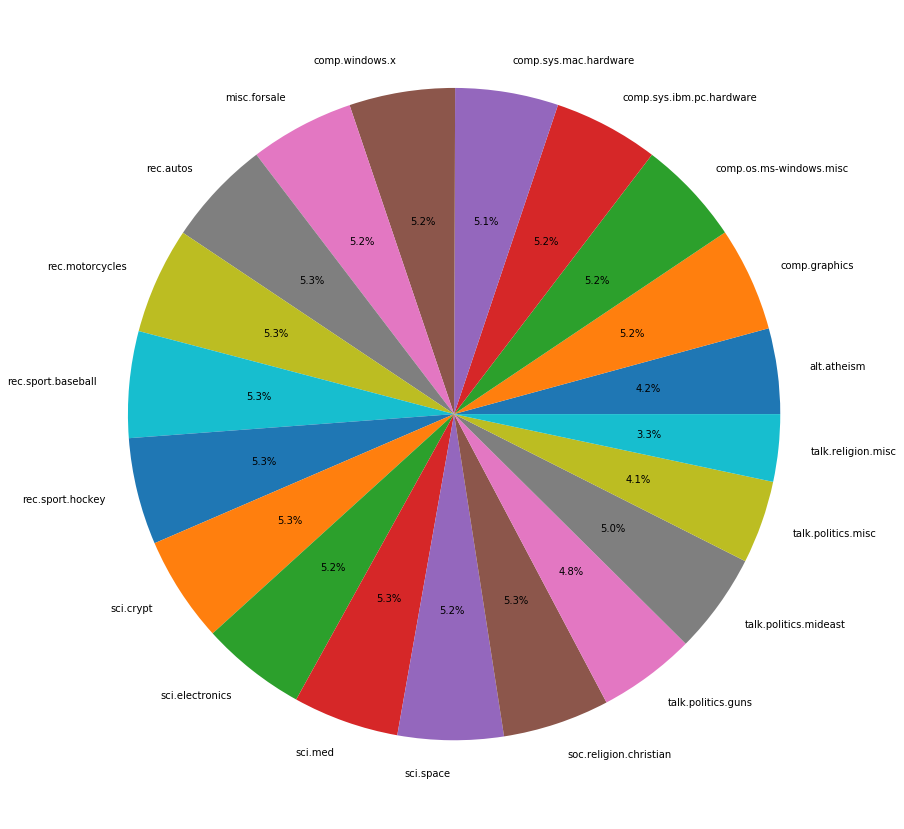

In [2]:
labels = news.target_names
sizes = [ Counter(news.target)[i] for i in range( len(labels) ) ]
plt.figure( figsize=(20,15) )
plt.pie(sizes ,  labels=labels , autopct='%1.1f%%')
plt.show()

#### Now we try to implement different feature extractors and classifiers on this dataset to see what is the best performing model based on classical methods.
First we split data into Train/Test which are needed for a fair comparison of models afterwards (inside train function) and then we evaluate model using its accuracy ( using classifier.score method which is prebuilt in sklearn.)


In [3]:
def train(classifier, X, y , rnd_state_input , test_split_size = 0.2 , print_result=True ):
    X_train, X_test, y_train, y_test = train_test_split( X, y , 
                                                    test_size=test_split_size , random_state=rnd_state_input )
    classifier.fit(X_train, y_train)
    if print_result:
        print("Accuracy: " , classifier.score(X_test, y_test) )
        return classifier
    else:
        return classifier.score( X_test, y_test )


Now we implement different classifiers using different feature extractors and classifiers.
Lets first start with a simple TFIDF vectorizer with a single decision tree and see how the model performs with very simple architectures.

In [4]:
train_split_random_state = 11


#The simplest model in either feature extractor and also classifier
classifier_vanilla1 = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', 
                                                                DecisionTreeClassifier( random_state=1 ) ) ])
print("Decision Tree performance:")
model_vanilla1 = train( classifier_vanilla1 , news.data, news.target , train_split_random_state)



#let's make the classifier a little bit more complex by adding more decision tree in a random forest
classifier_vanilla2 = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', 
                                                RandomForestClassifier( n_estimators=20, random_state=1)) ])
print("\nRandom forest performance:")
model_vanilla2 = train( classifier_vanilla2 , news.data, news.target , train_split_random_state)







Decision Tree performance:
Accuracy:  0.6445623342175066

Random forest performance:
Accuracy:  0.7525198938992043


As can be seen from above results, we can see that a single decision tree is a biased model, which improves by a large margin when more trees are added. Before, diving deep into how we can find the best architecture for our dataset, let's first visualize how the confusion matrix looks like using "model2" predictions which is a relatively small random forest.

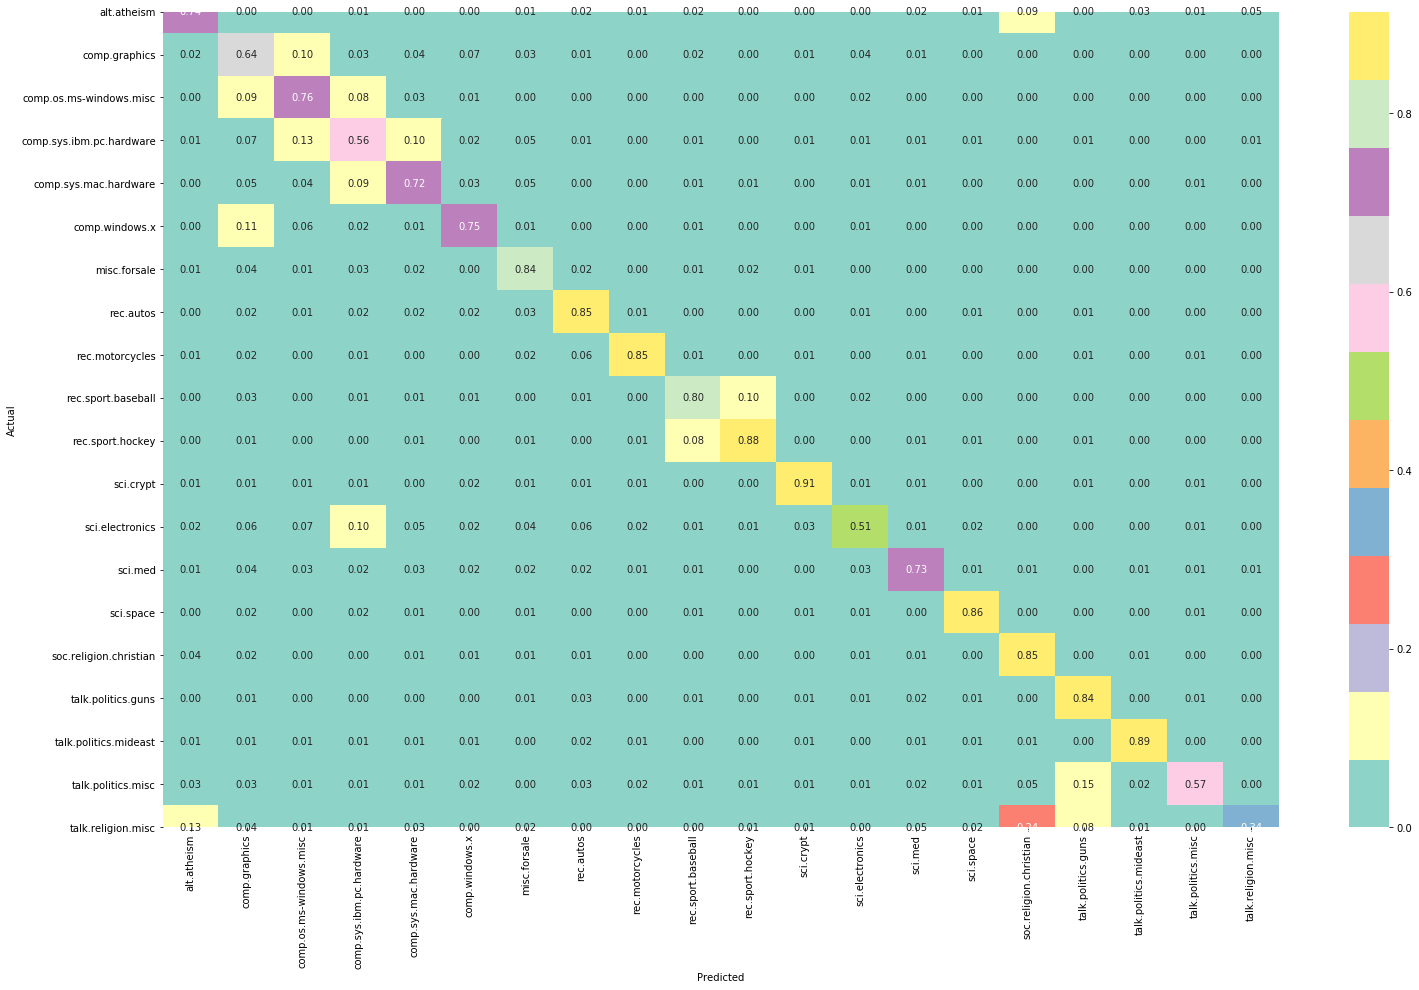

In [5]:
X_train, X_test, y_train, y_test = train_test_split(news.data, news.target, 
                                                    test_size=0.2, random_state=train_split_random_state)
y_pred = model_vanilla2.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat = normalize(confusion_mat , axis=1 , norm='l1' )
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap( confusion_mat, annot=True, cmap = "Set3", fmt ="0.2f", xticklabels=labels, yticklabels=labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


As we can see even a small random forest can at least cluster similar news articles close to each other in the space ( In the table, similar concepts are mostly lied close to each other). Therefore, using a more complex classifier without even changing the feature extractor would probably help distinguishing these close classes from each other. (you can check right now how increasing the number of trees can affect the model performance, with using e.g. 100 trees and then try to visualize how the confusion matrix will differ from it's current state)
However, there're still some conceptually different articles which the model cannot distinguish which wont probably resolved by just using a better classifier.
Now let's try finding a reasonble performance by trying different architectures on the validation set, and then evaluating the best performing model on the held-out test data set.

In [7]:
train_split_random_state = 11
train_validation_random_state = [1,5,10,15,20]
train_validation_split_size = 0.1

X_train, X_test, y_train, y_test = train_test_split( news.data, news.target , 
                            test_size=0.2 , random_state=train_split_random_state )
    

    
##let's first check few model performance, and then we introduce a better approach for finding the best 
##performing model on the validation set

classifier1 = Pipeline([ ('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB(alpha=0.2) ) ])

scores1 = np.array([ train (classifier1, X_train, y_train, i , test_split_size = train_validation_split_size
                                        , print_result=False ) for i in train_validation_random_state] )
print("TFIDF + naive bayes classifier:" , scores1.mean() )



classifier1_stop = Pipeline([ ('vectorizer', TfidfVectorizer( stop_words=stopwords.words('english')
                                                ) ), ('classifier', MultinomialNB(alpha=0.005) ) ])
scores1_stop = np.array( [train (classifier1_stop, X_train, y_train, i, test_split_size=train_validation_split_size
                                       , print_result=False ) for i in train_validation_random_state] )
print("TFIDF (by removing stop words) + (optimized) naive bayes classifier performance:" , scores1_stop.mean() )


classifier2 = Pipeline([ ('vectorizer', TfidfVectorizer( stop_words=stopwords.words('english')
                                                ) ), ('classifier', LinearSVC() ) ])
scores2 = np.array( [ train (classifier2 , X_train, y_train, i, test_split_size=train_validation_split_size
                                       , print_result=False ) for i in train_validation_random_state] )
print("TFIDF (by removing stop words) + support vector classifier performance:" , scores2.mean() )


classifier3 = Pipeline([ ('vectorizer', TfidfVectorizer( stop_words=stopwords.words('english')
                    ) ), ('classifier', RandomForestClassifier( n_estimators=150 , random_state=1) ) ])
scores3 = np.array( [train (classifier3 , X_train, y_train, i, test_split_size=train_validation_split_size
                                       , print_result=False ) for i in train_validation_random_state] )
print("TFIDF (by removing stop words) + random forest classifier performance:" , scores3.mean() )


classifier4 = Pipeline([ ('vectorizer', TfidfVectorizer( stop_words=stopwords.words('english')
            ) ), ('classifier', LogisticRegression(solver="lbfgs" , multi_class="auto", max_iter=500)  ) ])
scores4 = np.array( [train (classifier4 , X_train, y_train, i, test_split_size=train_validation_split_size
                                       , print_result=False ) for i in train_validation_random_state] )
print("TFIDF (by removing stop words) + linear regression classifier performance:" , scores4.mean() )


TFIDF + naive bayes classifier: 0.896153846153846
TFIDF (by removing stop words) + (optimized) naive bayes classifier performance: 0.913527851458886
TFIDF (by removing stop words) + support vector classifier performance: 0.9339522546419097
TFIDF (by removing stop words) + random forest classifier performance: 0.8594164456233422
TFIDF (by removing stop words) + linear regression classifier performance: 0.9084880636604774


According to above (average) accuracies on validation set, we can assume that the support vector classifier is the best performing model among the considered architecture on TFIDF. Let's first start with evaluating the best performing model performance on the held-out test dataset, and to also check the new confusion matrix on it.

best performing model (on validation set) performance on held-out test dataset:
Accuracy:  0.9320954907161804


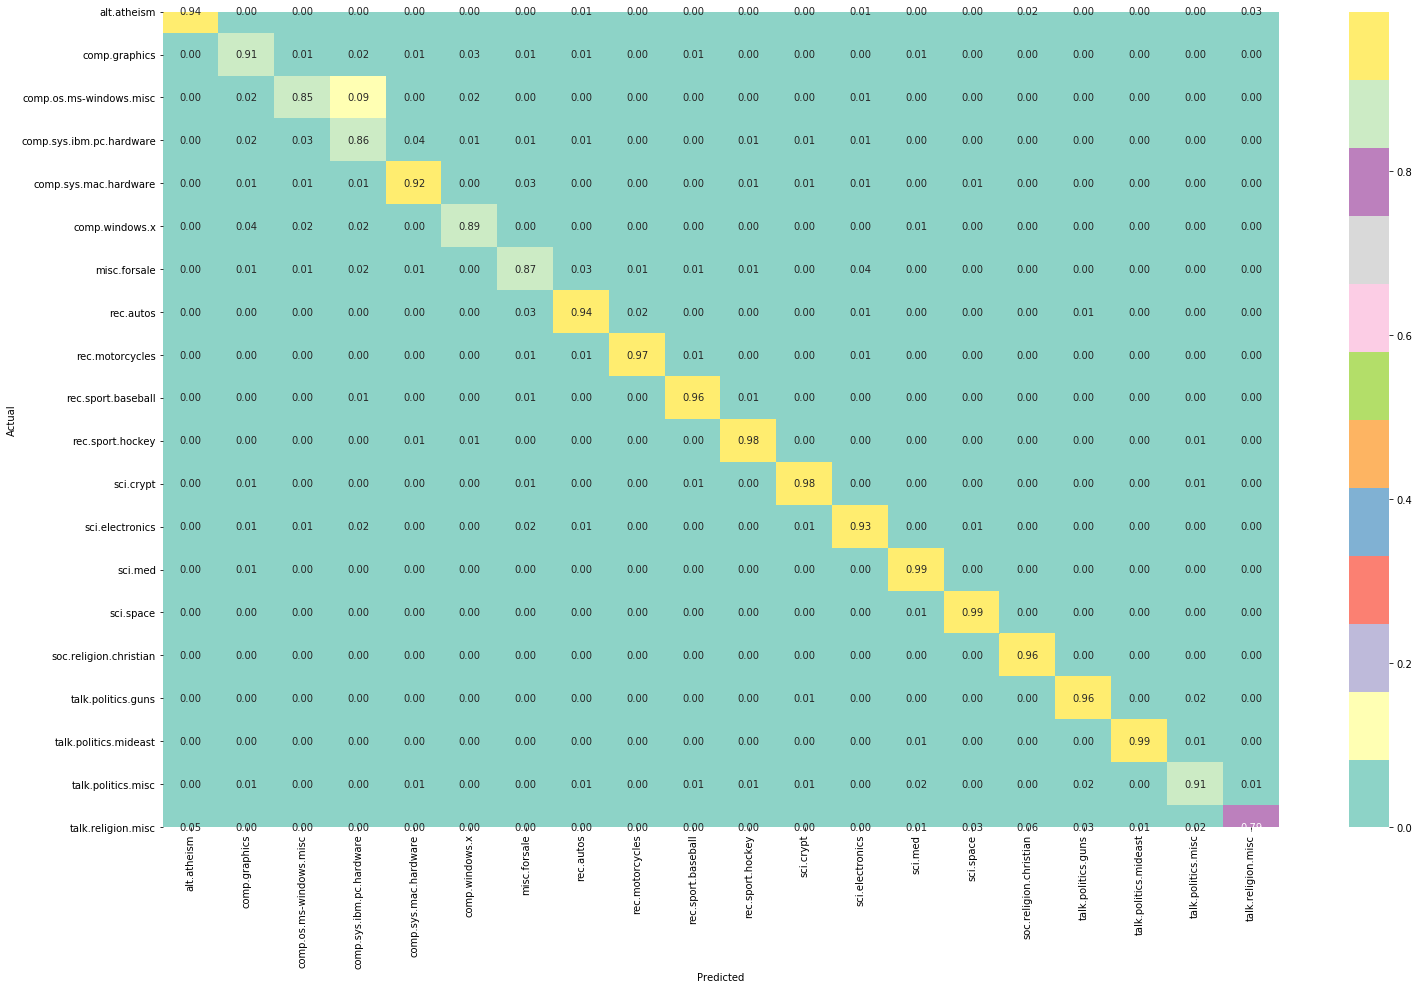

In [123]:
print("best performing model (on validation set) performance on held-out test dataset:")
model_star = train (classifier2 , news.data, news.target , train_split_random_state , test_split_size=0.2
                                        , print_result=True )

y_pred = model_star.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat = normalize(confusion_mat , axis=1 , norm='l1' )
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap( confusion_mat, annot=True, cmap = "Set3", fmt ="0.2f", xticklabels=labels, yticklabels=labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Let's also have a look at each class precision/recall/Fscore to have a better understanding of our model weaknesses/strengths

In [126]:
print( classification_report(y_test, y_pred, target_names=labels) )

                          precision    recall  f1-score   support

             alt.atheism       0.96      0.94      0.95       172
           comp.graphics       0.87      0.91      0.89       184
 comp.os.ms-windows.misc       0.92      0.85      0.88       204
comp.sys.ibm.pc.hardware       0.82      0.86      0.84       195
   comp.sys.mac.hardware       0.93      0.92      0.92       195
          comp.windows.x       0.94      0.89      0.91       204
            misc.forsale       0.86      0.87      0.86       164
               rec.autos       0.92      0.94      0.93       180
         rec.motorcycles       0.96      0.97      0.97       173
      rec.sport.baseball       0.97      0.96      0.97       217
        rec.sport.hockey       0.96      0.98      0.97       178
               sci.crypt       0.96      0.98      0.97       197
         sci.electronics       0.91      0.93      0.92       199
                 sci.med       0.94      0.99      0.97       183
         

The confusion matrix looks now so much more "diagonal" compared to the previous matrix, and also the overall accuracy of more than 93% is also so much better than our initial naive baseline.
As can be seen in the confusion matrix, SVC still cant effectively distinguish between few conceptually close topics, which is natural for a simple TFIDF feature extractor that ignores order and also "semantic" of words in the text which more complex models (e.g. nueral models) are able to capture more effectively.
Moreover, as you might guess 20 news-group classification is not a very challenging dataset and even simple models can achieve reasonable performance; In other words, there're more challenging tasks (e.g. hate speech detection in social media) in which using complex neural models yields significant boost in performance compared to standard methods.
We also investigate the effect of ensembling on model performance, as in most cases it can lead to better performance (at the cost of more training time)

In [9]:
ensemble_classifier = Pipeline( [ ('vectorizer', TfidfVectorizer( stop_words=stopwords.words('english')  ) ),
             ('classifier', VotingClassifier( estimators = [ 
                     ('nb', MultinomialNB( alpha=0.005 ) ) 
                    , ('svc', SVM.SVC( kernel="linear" , probability=True) ) , 
                    ('rf', RandomForestClassifier( n_estimators=150 , random_state=1) )
                , ( 'reg', LogisticRegression(solver="lbfgs", multi_class="auto" , max_iter=500 )  ) ]
                                 , voting="soft" , weights = [ 0.9135 , 0.9339 , 0.8594 , 0.9084] )  ) ] )

## The best weight values should be explored on the validation set to end-up with the best performing model
## once they are used in a soft voting scenario. Here we just use their average accuracy on the validation
## set which is for sure not optimal, but is also better than giving equal weight to all of them. We can see
## that even with this naive approach, it can still outperform the best model by around 0.3%

model_ensemble = train (ensemble_classifier , news.data, news.target , train_split_random_state ,
                                test_split_size=0.2 , print_result=True )



Accuracy:  0.9347480106100796


If you are wondering how hyper parameter search can be done efficiently in sklearn without writing every permutation separately, you might find this link useful:  
#### https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
It uses sklearn.model_selection.GridSearchCV to search for different hyperparameters that best fit the training data. It also uses multiprocessing to accelerate the grid search procedure. Therefore, we simply define again a complete pipeline (feature extractor + classifier) , but this time we also have a separate "Parameter" variable which stores all the desired parameter space to search from.
Please note that the approach that is used in this link can be used with a single classifier, however, if you want to also test different classifers, you should write a separate "Switcher" class that can handle any estimator, and then pass it to the pipeline as the "classifier". You can find more about this trick in this SO answer:
#### https://stackoverflow.com/a/53926103